In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import pickle
import learn_utils
import meta_features as mf
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import butter, lfilter, filtfilt
from tabulate import tabulate
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from detect_peaks import detect_peaks
from gaussian_kde import gaussian_kde
from sklearn.neighbors import KernelDensity
from operator import itemgetter

import scipy.signal as signal
import matplotlib.pyplot as plt

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Loading files names

In [2]:
def loadFile(file_name, directory, verbose=False):
    ##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
    # THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

    csv_data = None          # the variable where the loaded csv data is stored.
    num_windows = 0          # the number of windows loaded.
    windows = []             # the list of windows data. Each element is a pandas dataframe 
                             #  corresponding to the windows. The list is of size 'num_windows'.

    ignore_col_list = ['/ext_usb_camera/image/compressed', 'robogame/imu_state']
    
    #print '-- Processing: "{}"'.format(file_name)

    # load the data, abort in case of error.
    try:
        num_windows, csv_data = getCSV(os.path.join(directory, file_name))
    except ValueError as e:
        print traceback.format_exc()
        sys.exit(-1)

    for w in range(num_windows):
        win_data = {}
        for k in csv_data.keys():
            # consider the data only if it is not in the ignore list.
            if k not in ignore_col_list:
                if  csv_data[k][w] == []:
                    raise ValueError("\tFile has empty tagged windows. Skipping...")
                win_data[feature_name_map[k]] = csv_data[k][w]
                
        # convert dictionary to dataframe and save it to list of all windows data for the file.
        windows.append(pd.DataFrame.from_dict(win_data))
    
    #print '-- Retrieved {} windows in {}'.format(num_windows, file_name)
    
    if verbose:
        overlap_reference = 50
        try:
            _, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)
            print "LOAD SUMMARY:"
            print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                               headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])
        except ValueError as e:
            print traceback.format_exc()
            return None
    return windows

In [3]:
def moving_rmsV1(x, window):
    """Moving RMS of 'x' with window size 'window'."""
    window = 2*window + 1
    return np.sqrt(np.convolve(x*x, np.ones(window)/window, 'same'))

In [4]:
csv_dir = "../data/annotated_csv/"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

In [5]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


In [6]:
def getTimeline(listOfFiles, directory):
    failed_files = []
    frequences = []

    time_dataset = []   #saves the timeline
    
    for f in listOfFiles:
        csv_filename = f
        file_data = []             # the list of windows data. Each element is a pandas dataframe 
                                 #  corresponding to the windows. The list is of size 'num_windows'.

        #print 'Processing: "{}"'.format(csv_filename)

        # load the data, abort in case of error.
        try:
            file_data = loadFile(csv_filename, directory)
        except ValueError as e:
            #print traceback.format_exc()
            failed_files.append(csv_filename)
            continue

        time_line      = []
        
        #print '-- Normalizing accelerometer data...'
        for i, w in enumerate(file_data):
            for t in w['time'].dropna().as_matrix():
                time_line.append(t)

        
        time_dataset.append((time_line, csv_filename))
    return time_dataset

In [7]:
##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
# THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

def processFiles(listOfFiles, directory):
    failed_files = []
    frequences = []

    prox_dataset = []
    ci_dataset = []
    time_dataset = []   #saves the timeline
    
    for f in listOfFiles:
        csv_filename = f
        file_data = []             # the list of windows data. Each element is a pandas dataframe 
                                 #  corresponding to the windows. The list is of size 'num_windows'.

        #print 'Processing: "{}"'.format(csv_filename)

        # load the data, abort in case of error.
        try:
            file_data = loadFile(csv_filename, directory)
        except ValueError as e:
            #print traceback.format_exc()
            failed_files.append(csv_filename)
            continue

        proximity = []
        ci        = []
        time_line      = []
        
        time_interval = 0
        #print '-- Normalizing accelerometer data...'
        for i, w in enumerate(file_data):
            if i==0:
                time_interval = w['time'].iloc[-1]
                for c, p, t in zip(w['ci'].dropna().as_matrix(), w['proximity'].dropna().as_matrix(), w['time'].dropna().as_matrix()):
                    if c > 1:
                        ci.append(1)
                    else:
                        ci.append(c)
                    if p > 1:
                        proximity.append(1)
                    else:
                        proximity.append(p)
                    
                    time_line.append(t)
            else:
                values = list(set(w['time']) - set(file_data[i-1]['time']))
                time_interval = w['time'].iloc[-1]
                result = w[w['time'].isin(values)]
                for c, p, t in zip(w['ci'].dropna().as_matrix(), w['proximity'].dropna().as_matrix(), w['time'].dropna().as_matrix()):
                    if c > 1:
                        ci.append(1)
                    else:
                        ci.append(c)
                    if p > 1:
                        proximity.append(1)
                    else:
                        proximity.append(p)

                    time_line.append(t)

        N_samps = len(ci)
        Fs = N_samps/time_interval
        frequences.append(Fs)

        ##### COMPUTING THE AC COMPONENT  (Transformation I: Offset Translation) ####
        #proximity_AC = np.array(proximity) - np.mean(proximity)
        #ci_AC = np.array(ci) - np.mean(ci)
        ####

        #### Transformation II: Amplitude Scaling ####
        proximity_Scaled = proximity #proximity_AC / np.std(proximity_AC)
        ci_Scaled = ci #ci_AC / np.std(ci_AC)

        ##### SMOOTH USING BUTTERWORTH FILTER #####
        # Butterworth filter properties
        # Correct the cutoff frequency for the number of passes in the filter
        #C = 0.802
        #freq = Fs   # Calculating frequency
        #b, a = butter(3, (5/C)/(freq/2), btype = 'low') # BF order 3
        ## applying butterworth filter for x axis, filter with phase shift correction
        #proximity_filtered = filtfilt(b, a, proximity_Scaled)
        #ci_filtered = filtfilt(b, a, ci_Scaled)
        ####

        # Moving RMS filter
        proximity_filtered = moving_rmsV1(np.array(proximity_Scaled), 15)
        ci_filtered = moving_rmsV1(np.array(ci_Scaled), 15)
        
        #### COMPUTE MAGNITUDE VECTOR #####
        #mag = []
        #for i in range(len(norm_dataX)): #all tree axis data are the same length
        #    mag.append(np.sqrt(norm_dataX[i]**2 + norm_dataY[i]**2 + norm_dataZ[i]**2))

        ##### SMOOTH MAGNITUDE USING RUNNING AVERAGE #####
        #dataX_filtered = compute_runavg_acc(allAccX, N=2)
        #dataY_filtered = compute_runavg_acc(allAccY, N=2)
        #dataZ_filtered = compute_runavg_acc(allAccZ, N=2)
        
        ##### computing jerk #####
        #jerk = []
        #for i in range(len(vect)):
        #    if i-1 < 0:
        #        jerk.append(vect[i])
        #    else:
        #        jerk.append(vect[i] - vect[i-1])

        ### PLOTTING SIGNAL ####
        #print "-- Time interval: ", str(time_interval)
        ## the period represents the oscilation. It's  the sample time, the time after which each data come.
        #T = 1./Fs
        #t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.
        #fig, ax = plt.subplots(1,1, figsize=(18,8))
        #ax.plot(t,dataX_Scaled, c='g', label='Scaled')
        #ax.plot(t,dataX_AC, c='r', label='AC')
        #ax.plot(t,dataX_filtered, c='m', label='Filtered')
        #ax.plot(t,allAccX, c='b', label='Original')
        #ax.plot(t,norm_dataZ, c='r', label='Z')
        #ax.set_ylabel("g's")
        #ax.set_ylim(0,0.05)
        #ax.set_xlabel('Time (secs)')
        #plt.title("Magnitude of the accelerometer for {} file".format(csv_filename))
        #plt.legend()
        #plt.yscale('log')
        #plt.draw()


        #sys.exit(0)

        #### SAVE TO .MAT #####
        #save_to_dir = './mat_xyz_files_preprocessed'
        #name_to_save = os.path.join(save_to_dir,'{}.mat'.format(csv_filename))
        #print '-- Saving to: {}'.format(name_to_save)
        #sio.savemat(name_to_save, {'x_axis':dataX_filtered,'y_axis':dataY_filtered,'z_axis':dataZ_filtered})
        #print
        prox_dataset.append((list(proximity_filtered),csv_filename))
        ci_dataset.append((list(ci_filtered),csv_filename))
        time_dataset.append((time_line, csv_filename))
    return (prox_dataset, ci_dataset,frequences,time_dataset)
#print 'Files average frequency of {} with std. deviation of {}'.format(np.mean(frequences),np.std(frequences))

## Windows details

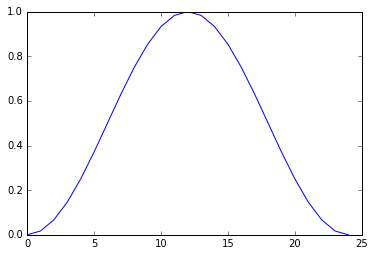

In [8]:
segment_len = 25   # WINDOWS SIZE
slide_len = 5      # WINDOWS OVERLAP

### windowing function
window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
plt.plot(window)
plt.show()

In [15]:
%matplotlib inline
filehandler = open("frequences.pkl","rb")
file_frequences = pickle.load(filehandler)
filehandler.close()

## Extracts energy features and deviation from the data
def activita(df,freq, time):
    result = []
    
    font = {'family': 'serif',
        'color':  'green',
        'weight': 'normal',
        'size': 10,
        }
    
    for i in range(df.shape[0]):
        f_number = i

        proximity_segments = []
        ci_segments = []
        
        proximity_energies = []
        ci_energies = []

        proximity_std = []
        ci_std = []
        
        comb_std = []

        #for i in range(df.shape[0]):
        proximity = df['ci'].tolist()[f_number]
        ci = df['proximity'].tolist()[f_number]
        filecsv = df['file'].tolist()[f_number]
        Fs         =  freq[f_number] #file_frequences[df['file'].tolist()[f_number]] # 
        N_samps    = len(proximity)
        for start_pos in range(0, len(proximity), slide_len):
            end_pos = start_pos + segment_len
            # make a copy so changes to 'segments' doesn't modify the original ekg_data
            prox_segment = np.copy(proximity[start_pos:end_pos])
            ci_segment = np.copy(ci[start_pos:end_pos])
    
            # if we're at the end and we've got a truncated segment, drop it
            if len(prox_segment) != segment_len:
                continue
            
            ## MULTIPLY BY WINDOWING FUNCTION TO ATTENUATE WINDOWS ENDPOINTS.
            prox_segment = prox_segment * window
            ci_segment = ci_segment * window

            proximity_segments.append(prox_segment)     
            ci_segments.append(ci_segment)
            
            proximity_energies.append(mf.fft_energy(prox_segment))
            ci_energies.append(mf.fft_energy(ci_segment))

            stdprox = np.std(prox_segment)
            stdci = np.std(ci_segment)

            proximity_std.append(stdprox)
            ci_std.append(stdci)
            
            comb_std.append(np.mean([proximity_std,ci_std]))

        t  = df['time'][f_number][0]
        #t  = np.linspace(0,N_samps*(1/Fs),N_samps) # N_samps*T (#samples x sample period) is the signal time.


        #print (len(the_data_x)/4) -8
        a = np.arange(0,len(t),5 *(1/Fs))
        p = a[:int(len(proximity_energies))]
        c = a[:int(len(ci_energies))]


        fig = plt.figure(figsize=[12,7])
        ax0 = plt.subplot(411)
        ax0.plot(t,proximity, label='prox')
        ax0.plot(t,ci, label='ci')
        ax0.set_ylabel('ci/proximity')
        ax0.set_xticks(np.arange(0,t[-1],3))
        
        #plt.grid()
        #plt.legend(loc='best', frameon=False, fontsize=8)
        #ax1 = plt.subplot(412, sharex=ax0)
        #ax1.plot(p,proximity_energies, label='prox_energy')
        #ax1.plot(c,ci_energies, label='ci_energy')
        #ax1.set_ylabel('energy')
        #plt.grid()
        #plt.legend(loc='best', frameon=False, fontsize=8)
        #ax2 = plt.subplot(413, sharex=ax0)
        #ax2.plot(c,proximity_std, label= 'prox')
        #ax2.plot(c,ci_std, label= 'ci')
        #ax2.set_ylabel('std')
        #plt.grid()
        #plt.legend(loc='best', frameon=False, fontsize=8)
        #ax3 = plt.subplot(414, sharex=ax0)
        #ax3.plot(c,comb_std, label= 'avg')
        #sio.savemat(df['file'].tolist()[f_number], {'x':comb_std})
        
        # inactive threshold
        #mu = 0.2
        #start = -1
        #for i,d in enumerate(comb_std):
        #    dictionary = {}
        #    if (d >= mu) and (start < 0):
        #    #if (np.abs((d - mu)/sigma) > var_thd * sigma) and (start < 0):
        #        start = i
        #    elif (i == (len(comb_std)-1)):
        #        ax3.fill_between(c[start:i],comb_std[start:i],0,color='0.8')
        #        peaks = detect_peaks(comb_std[start:i], mph=mu, show=False)
        #        peak_values = [(comb_std[start:i][p],p) for p in peaks]
        #        ax3.scatter([c[start:i][k] for k in peaks], [p[0] for p in peak_values], marker='x', color='r')
        #        
        #        if len(peaks) !=0:
        #            int_data = np.array(comb_std[start:i])
        #            max_peak, peak_pos = max(peak_values,key=itemgetter(0))
        #            dictionary['max_peak'] = max_peak
        #            dictionary['mean_peak'] = np.mean(peak_values)
        #            delta_T = c[i] - c[start]
        #            activity_area = delta_T * max_peak
        #            activity_ci = (np.sum(int_data) - activity_area) / float(activity_area)
        #            dictionary['ci'] = activity_ci
        #            dictionary['mean'] = np.mean(int_data)
        #            dictionary['pse'] = mf.pse(int_data)
        #            dictionary['num_peaks'] = len(peaks)
        #            dictionary['dt'] = delta_T
        #            dictionary['act'] = int_data
        #            dictionary['dt_samples'] = c[start:i]
        #            dictionary['file'] = filecsv
        #            ax3.text(c[start:i][int(len(c[start:i])/4)], np.random.choice(np.arange(0.1, 1, 0.1)), str(len(result)), fontdict=font)
        #            result.append(dictionary)
                    
        #    elif (d < mu) and (start >= 0):
        #        peaks = detect_peaks(comb_std[start:i], mph=mu, show=False)
        #        peak_values = [(comb_std[start:i][p],p) for p in peaks]
        #        ax3.scatter([c[start:i][k] for k in peaks], [comb_std[start:i][p] for p in peaks], marker='x', color='r')
        #        ax3.fill_between(c[start:i],comb_std[start:i],0,color='0.8')
        #        if len(peaks) !=0:
        #            int_data = np.array(comb_std[start:i])
        #            max_peak, peak_pos = max(peak_values,key=itemgetter(0))
        #            dictionary['max_peak'] = max_peak
        #            dictionary['mean_peak'] = np.mean(peak_values)
        #            delta_T = c[i] - c[start]
        #            activity_area = delta_T * max_peak
        #            activity_ci = (np.sum(int_data) - activity_area) / float(activity_area)
        #            dictionary['ci'] = activity_ci
        #            dictionary['mean'] = np.mean(int_data)
        #            dictionary['pse'] = mf.pse(int_data)
        #            dictionary['num_peaks'] = len(peaks)
        #            dictionary['dt'] = delta_T
        #            dictionary['act'] = int_data
        #            dictionary['dt_samples'] = c[start:i]
        #            dictionary['file'] = filecsv
        #            ax3.text(c[start:i][int(len(c[start:i])/4)], np.random.choice(np.arange(0.1, 1, 0.1)), str(len(result)), fontdict=font)
        #            result.append(dictionary)
        #        start = -1
            
        #ax3.axhline(y=mu, color='r', marker='.')

        #combined = [i+j+k for i,j,k in zip(x_energies,y_energies,z_energies)]
        #plt.plot(z,combined, label='combined')
        #ax3.set_xlabel('seconds')
        #ax3.set_ylabel('Combined variance')
        plt.grid()
        
        plt.xlim(0,plt.xlim()[1])
        plt.legend(loc='best', frameon=False, fontsize=8)

        fig.suptitle('{}'.format(df['file'].tolist()[f_number] + ' {:.2f}'.format(Fs)), fontsize=21)
        fig.subplots_adjust(hspace=0.3, wspace= 0.5)
        plt.draw()


        print("Produced %d waveform segments" % len(proximity_segments))
    return result

In [10]:
arm_csv_dir = "../data/new_data/"
files_arm = getListOfFiles(arm_csv_dir, ".csv")
#print ">> {} CSV Files found:\n".format(len(files_arm))
#print json.dumps(files_arm)

In [11]:
time_all = getTimeline(files,csv_dir)
proximity, ci, freq, time = processFiles(files,csv_dir)

In [12]:
dic = {'ci'   :[c[0] for c in ci],
       'proximity'   :[p[0] for p in proximity],
       'file':[f[1] for f in ci],
       'freq': freq,
       'time': time
      } 
arm_df = pd.DataFrame(dic, columns=['ci','proximity','file', 'freq','time'])

## Save dataframe

In [17]:
from sklearn.externals import joblib
joblib.dump(arm_df, 'ci_proximity.pkl') 

['ci_proximity.pkl']

Produced 202 waveform segments
Produced 239 waveform segments
Produced 92 waveform segments
Produced 184 waveform segments
Produced 233 waveform segments
Produced 307 waveform segments
Produced 466 waveform segments
Produced 166 waveform segments
Produced 168 waveform segments
Produced 277 waveform segments
Produced 141 waveform segments
Produced 217 waveform segments
Produced 276 waveform segments
Produced 255 waveform segments
Produced 407 waveform segments
Produced 214 waveform segments
Produced 207 waveform segments
Produced 131 waveform segments
Produced 160 waveform segments
Produced 470 waveform segments


/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Produced 390 waveform segments
Produced 539 waveform segments
Produced 266 waveform segments
Produced 235 waveform segments
Produced 269 waveform segments
Produced 210 waveform segments
Produced 397 waveform segments
Produced 166 waveform segments
Produced 631 waveform segments


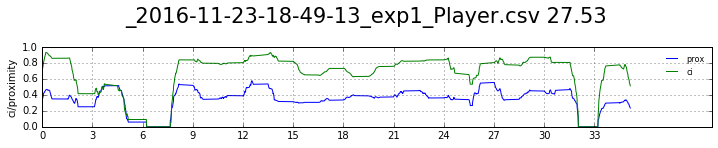

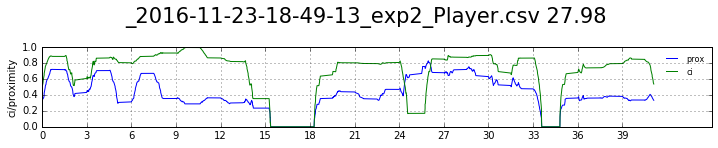

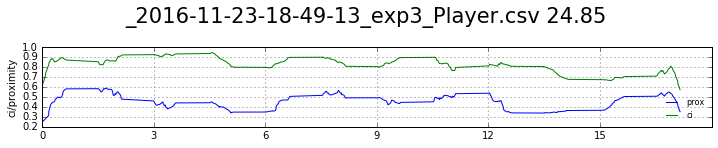

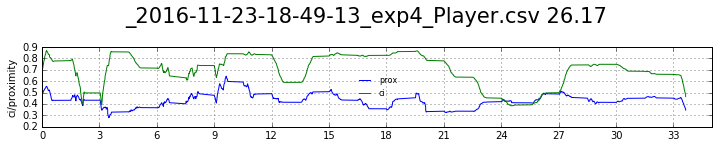

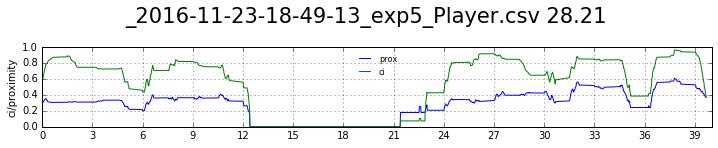

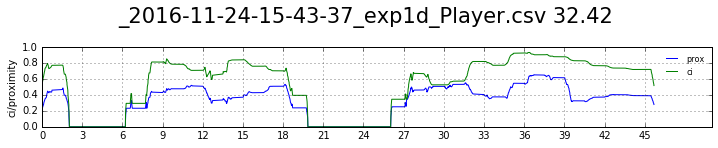

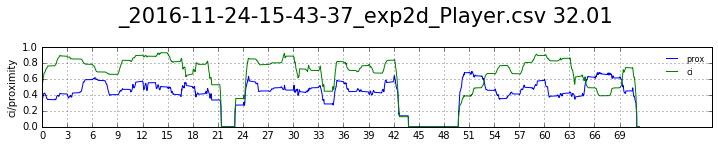

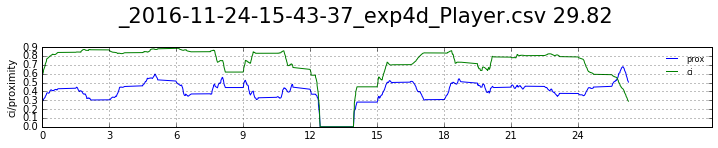

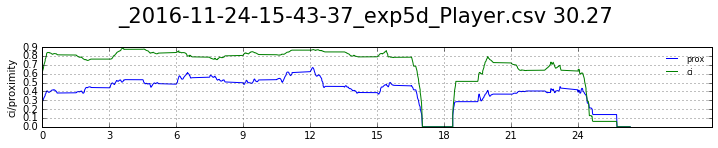

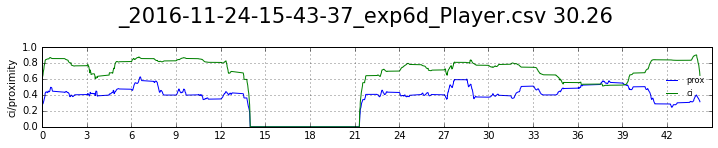

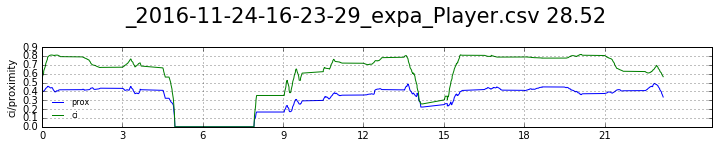

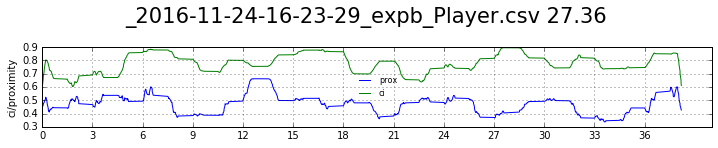

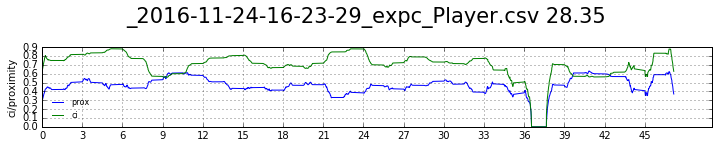

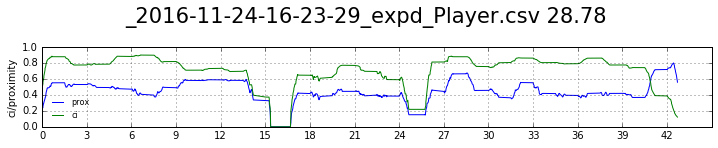

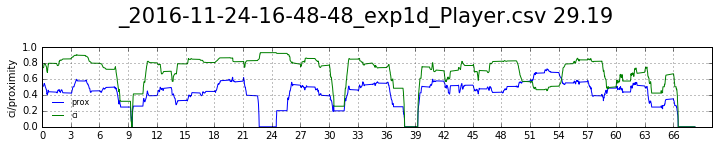

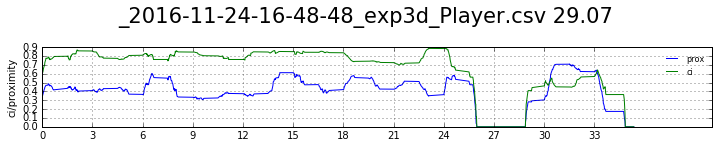

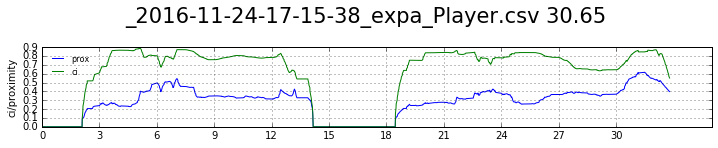

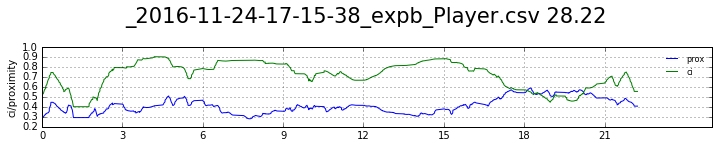

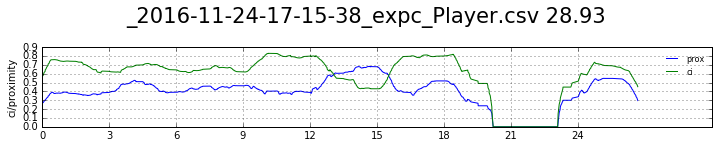

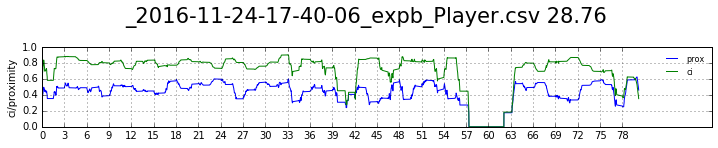

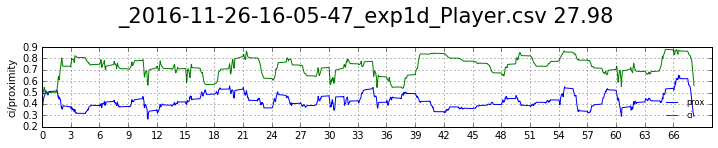

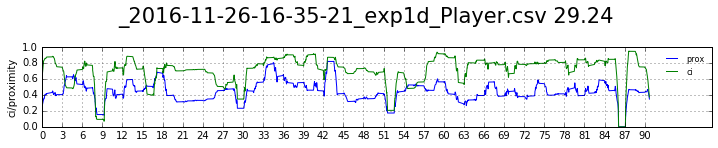

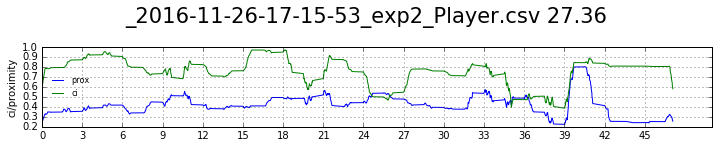

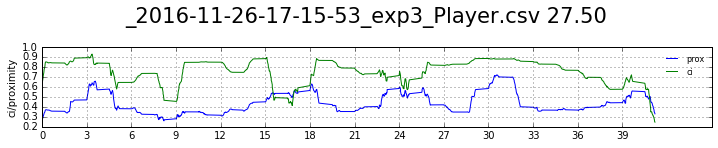

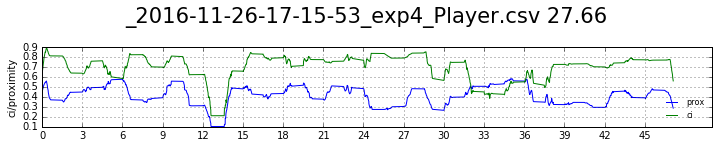

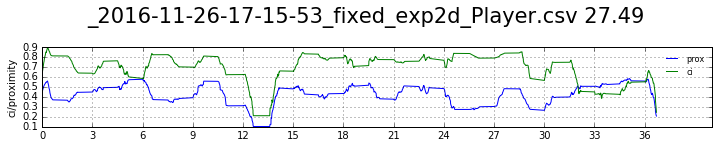

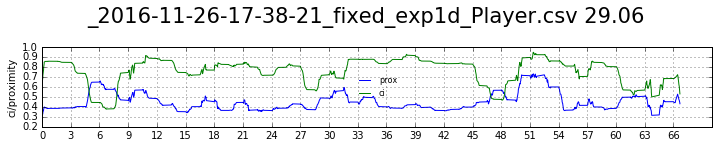

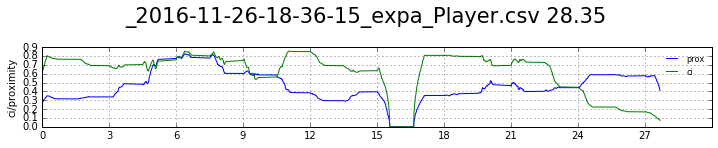

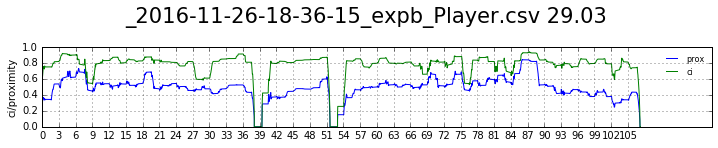

In [16]:
res = activita(arm_df,freq, time)

## Export data

In [ ]:
from sklearn.externals import joblib
joblib.dump(res, 'ci_proximity.pkl') 